In [1]:
# Change the dataset in global_vars.py to UKB.

from global_vars import *
from func import *

import pickle as p
import glob 
import json
import subprocess
import getpass
import os

In [2]:
# ",".join(os.listdir('/home/abhijit/Jyotirmay/abdominal_segmentation/quickNAT_pytorch/create_datasets/datasets/lablmaps/UKB'))
# vol_to_check_list = ['1013391_20201_2_0']

In [3]:
data_dir

'/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti'

In [4]:
def load_ukb_file_paths(load_from_txt_file=True):
    volumes_to_use = []
    if load_from_txt_file:
        with open(volume_txt_file) as file_handle:
                volumes_to_use = file_handle.read().splitlines()
    else:
        volumes_to_use = [name for name in os.listdir(data_dir)]
    
    file_paths = {}
    
    for vol in volumes_to_use:
        if vol_to_check_list is not None and vol not in vol_to_check_list:
            continue
        opp_paths = glob.glob(f'{data_dir}/{vol}/**opp**_[17s, 17sa,17sb]**.nii.gz')
        in_paths = glob.glob(f'{data_dir}/{vol}/**in**_[17s,17sa,17sb]**.nii.gz')
        f_paths = glob.glob(f'{data_dir}/{vol}/**F**_[17s, 17sa,17sb]**.nii.gz')
        w_paths = glob.glob(f'{data_dir}/{vol}/**W**_[17s, 17sa,17sb]**.nii.gz')
        
        labelmap_paths = glob.glob(f'{label_dir}/{vol}/**')
        
        vol_madals_paths = dict(
        OPP=opp_paths,
        IN=in_paths,
        F=f_paths,
        W=w_paths
        )
        file_paths[str(vol)]=dict(
            VOLUME_PATHS=vol_madals_paths,
            LABEL_PATHS=labelmap_paths,
        )
    return file_paths
        

In [5]:
file_paths = load_ukb_file_paths()

In [6]:
 print(json.dumps(file_paths,sort_keys=True, indent=4))

{
    "1002359_20201_2_0": {
        "LABEL_PATHS": [
            "datasets/lablmaps/UKB/1002359_20201_2_0/1002359_opp_17sb_Spleen.nii_.nrrd",
            "datasets/lablmaps/UKB/1002359_20201_2_0/1002359_Dixon_BH_17s_opp_Dixon_BH_17sb.nrrd_Adrenal gland(right).nrrd",
            "datasets/lablmaps/UKB/1002359_20201_2_0/1002359_Dixon_opp_BH_17sb_combi_Kidney (right).nrrd",
            "datasets/lablmaps/UKB/1002359_20201_2_0/1002359_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_KIdney(left).nrrd",
            "datasets/lablmaps/UKB/1002359_20201_2_0/1002359Dixon_opp_BH_17sb.niiLiver (2)-2.nrrd",
            "datasets/lablmaps/UKB/1002359_20201_2_0/1002359_Dixon_BH_17s_opp_Dixon_BH_17sb.nrrd_Pancreas.nrrd",
            "datasets/lablmaps/UKB/1002359_20201_2_0/1002359_Dixon_BH_17s_opp_Dixon_BH_17sb.nrrd_Adrenal gland(left).nrrd",
            "datasets/lablmaps/UKB/1002359_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17_comb_01.nii.gz"
        ],
        "VOLUME_PATHS": {
            "F": [
              

In [7]:
# Individual RESCALING.
n4_dict = {}
for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-1 started with {vol}...')
    n4_dict[vol] = []
    vol_parts = [[file, read_ras(file)] for file in file_paths[vol]['VOLUME_PATHS']['IN']]
    for orig_file, in_image in vol_parts:
        n4_dict[vol].append(rescale(in_image, vol, orig_file))

In [8]:
# TODO: EXECUTE 'sudo sh ./n4-anne.sh' from command line for n4 bais field generation of all in imgs.

for vol in file_paths.keys():
    if one_time_n4_optimization:
        break
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'applying n4 bias field on opp scans of {vol}...')
    vol_parts = [[read_ras(opp_file), read_ras(n4_counterpart['IN_BIAS']), opp_file] for opp_file, n4_counterpart in zip(file_paths[vol]['VOLUME_PATHS']['OPP'],n4_dict[vol])]
    idx = 0
    file_paths[vol]['N4_1'] = []
    for opp_img, bias_field_img, opp_file in vol_parts:
        file_paths[vol]['N4_1'].append(apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol][idx], vol))
        idx+=1
#         n4_dict[vol].append(rescale(opp_image, vol, n4_dict[vol]))



In [9]:
# STITCHING VOL PARTS HERE
for vol in file_paths.keys():
    print(f'started with {vol}...')
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    create_if_not(f'{n4_corrected_data_dir}/vol/{vol}')
    file_paths[vol]['ONE'] = {}
#     file_paths[vol]['ONE_ORIG'] = {}
    for modality_key in file_paths[vol]['VOLUME_PATHS'].keys():
        print(f"processing {modality_key}")
        orig_modal_key = modality_key
        if one_time_n4_optimization:
            vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]
        else:
            if modality_key == 'OPP':
                vol_parts = [read_ras(data_dict['OPP_CORRECTED']) for data_dict in file_paths[vol]['N4_1']]
                modality_key = modality_key+'_n4_corrected'
            else:
                vol_parts = [read_ras(file) for file in file_paths[vol]['VOLUME_PATHS'][modality_key]]

        ras_stitched = multi_vol_stitching(vol_parts)
        save_volume(ras_stitched, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched')
#         save_volume(ras_stitched_orig, f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched_orig')
        file_paths[vol]['ONE'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched.nii.gz'
#         file_paths[vol]['ONE_ORIG'][f'{orig_modal_key}'] = f'{n4_corrected_data_dir}/vol/{vol}/{modality_key}_ras_stitched_orig.nii.gz'

started with 1138634_20201_2_0...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -462.75      ]
 [   0.            0.    

1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/3387088_20201_2_0
processing W
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.          

Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/1019631_20201_2_0
processing F
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -462.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    

Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/1013250_20201_2_0
processing IN
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293   

Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/1584559_20201_2_0
started with 1013391_20201_2_0...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -462.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833

0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/1108214_20201_2_0
processing W
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0

Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/5934622_20201_2_0
processing F
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    

0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/1026125_20201_2_0
processing IN
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -462.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   

0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/1005379_20201_2_0
started with 5371767_20201_2_0...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -462.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293

0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/4627690_20201_2_0
processing W
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0

Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/1004985_20201_2_0
processing F
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -462.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    

0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/5833278_20201_2_0
processing IN
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -462.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   

Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/1003082_20201_2_0
started with 6025746_20201_2_0...
processing OPP
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -462.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833

Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/5331775_20201_2_0
processing W
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -462.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    

Transforming Images to RAS.....
0th img for stitching...
1th img for stitching...
saving directory: temp/UKB/n4_corrected_2/vol/1002359_20201_2_0
processing F
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    0.         -191.96429443]
 [   0.            0.            4.5        -294.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (224, 174, 44)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.23214293    0.            0.         -247.7678833 ]
 [   0.            2.23214293    

In [11]:
# RESCALING INTENSITIES OF STITCHED VOLUME ABOVE 0
n4_dict = {}
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'n4 processing part-2 started with {vol}...')
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    n4_dict[vol] = {}
    in_stitched_file_path, in_stitched_img = file_paths[vol]['ONE']['IN'], read_ras(file_paths[vol]['ONE']['IN'])
    n4_dict[vol]['N4_2'] = rescale(in_stitched_img, vol, in_stitched_file_path)

n4 processing part-2 started with 1138634_20201_2_0...
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)
Transforming Images to RAS.....
-164.0
neagtive value detected
saving directory: temp/UKB/n4_corrected_2/vol/1138634_20201_2_0
n4 processing part-2 started with 3387088_20201_2_0...
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)
Transforming Images to RAS.....
-129.0
neagtive value detected
saving directory: temp/UKB/n4_corrected_2/vol/3387088_20201_2_0


n4 processing part-2 started with 1004985_20201_2_0...
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)
Transforming Images to RAS.....
-131.0
neagtive value detected
saving directory: temp/UKB/n4_corrected_2/vol/1004985_20201_2_0
n4 processing part-2 started with 1036900_20201_2_0...
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)
Transforming Images to RAS.....
-166.0
neagtive value detected
saving directory: temp/UKB/n4_corrected_2/vol/1036900_20201_2_0


In [12]:
# TODO: EXECUTE 'sudo sh ./n4-anne-2.sh' from command line for n4 bais field generation of all in imgs.
for vol in file_paths.keys():
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    print(f'applying n4 bias field on stitched opp scans of {vol}...')

    opp_file = file_paths[vol]['ONE']['OPP']
    n4_counterpart = n4_dict[vol]['N4_2']
    print(opp_file, n4_counterpart['IN_BIAS'])
    opp_img = read_ras(opp_file)
    bias_field_img = read_ras(n4_counterpart['IN_BIAS'])

    file_paths[vol]['N4_2'] = apply_bias_field(opp_img, bias_field_img, opp_file, n4_dict[vol]['N4_2'], vol)

applying n4 bias field on stitched opp scans of 1138634_20201_2_0...
temp/UKB/n4_corrected_2/vol/1138634_20201_2_0/OPP_ras_stitched.nii.gz temp/UKB/n4_corrected_2/vol/1138634_20201_2_0/IN_ras_stitched_n4_scaled_bias_field.nii.gz
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)
Transforming Images to RAS.....
saving directory: temp/UKB/n4_corrected_2/vol/1138634_20201_2_0
applyin

Transforming Images to RAS.....
saving directory: temp/UKB/n4_corrected_2/vol/1108214_20201_2_0
applying n4 bias field on stitched opp scans of 5397022_20201_2_0...
temp/UKB/n4_corrected_2/vol/5397022_20201_2_0/OPP_ras_stitched.nii.gz temp/UKB/n4_corrected_2/vol/5397022_20201_2_0/IN_ras_stitched_n4_scaled_bias_field.nii.gz
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)
Transfo

Transforming Images to RAS.....
saving directory: temp/UKB/n4_corrected_2/vol/1004985_20201_2_0
applying n4 bias field on stitched opp scans of 1036900_20201_2_0...
temp/UKB/n4_corrected_2/vol/1036900_20201_2_0/OPP_ras_stitched.nii.gz temp/UKB/n4_corrected_2/vol/1036900_20201_2_0/IN_ras_stitched_n4_scaled_bias_field.nii.gz
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)
Transforming Images to RAS.....
Reading Files.....
Reading Nifti Files.....
Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)
Transfo

In [14]:
file_paths

{'1138634_20201_2_0': {'VOLUME_PATHS': {'OPP': ['/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17s.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17sa.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17sb.nii.gz'],
   'IN': ['/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_in_Dixon_BH_17s_e2.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_in_Dixon_BH_17s_e2a.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_in_Dixon_BH_17s_e2b.nii.gz'],
   'F': ['/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_F_Dixon_BH_17s.nii.gz',
    '/home/abhijit/nas_drive/Data_WholeBody/UK

In [13]:
with open('ukb_file_paths.p', 'wb') as handle:
    p.dump(file_paths, handle, protocol=p.HIGHEST_PROTOCOL)

In [15]:
with open('ukb_file_paths.p', 'rb') as handle:
    file_paths = p.load(handle)

In [16]:
print(json.dumps(file_paths, indent=4))

{
    "1138634_20201_2_0": {
        "VOLUME_PATHS": {
            "OPP": [
                "/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17s.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17sa.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17sb.nii.gz"
            ],
            "IN": [
                "/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_in_Dixon_BH_17s_e2.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_in_Dixon_BH_17s_e2a.nii.gz",
                "/home/abhijit/nas_drive/Data_WholeBody/UKBiobank/body/body_nifti/1138634_20201_2_0/Dixon_BH_17s_in_Dixon_BH_17s_e2b.nii.gz"
            ],
            "F": [
             

In [17]:
def rectify(start, end, label_start, label_end, do_alter=False):
    if start < 0:
        if do_alter:
            start = np.abs(start)
            label_start = 0
            label_end = end
            end += start
        else:
            start = np.abs(start)
            end += start
#             label_end -= start
            start = 0
            
#             label_start = np.abs(start)
#             start = 0
#             end -= label_start

    return start, end, label_start, label_end

def ukb_vol_label_fix(vol, label):
    vol_vol = np.product(vol.shape)
    label_vol = np.product(label.shape)
    
    world_shape = np.max(np.array([list(vol.shape), list(label.shape)]), axis=0)
    print(tuple(world_shape))
    final_label = np.zeros(tuple(world_shape))
    
    label_affine = label.affine
    vol_affine = vol.affine
#         final_label = np.zeros(vol.shape)
    target_affine = vol_affine
    target_header = vol.header
    target_dim_v = vol.shape

    sx,sy,sz,ex,ey,ez = np.abs(get_points(label, vol))
#     print(sx,sy,sz,ex,ey,ez)
    labelmap = label.get_fdata()
#     print(final_label.shape, labelmap.shape)
#     l_end_x, l_end_y, l_end_z = labelmap.shape
#     print('XXX', sx, ex, l_end_x)
#     sx, ex, lsx, lex = rectify(sx, ex, 0, l_end_x, do_alter=False)
#     print(sx, ex, lsx, lex)
#     print('YYY',sy, ey, l_end_y)
#     sy, ey, lsy, ley = rectify(sy, ey, 0, l_end_y, do_alter=False)
#     print(sy, ey, lsy, ley)
#     print('ZZZ',sz, ez, l_end_z)
#     sz, ez, lsz, lez = rectify(sz, ez, 0, l_end_z, do_alter=False)
#     print(sz, ez, lsz, lez)
#     print(sx, sy, sx, ex, ey, ex, '---', lsx, lsy, lsz, lex, ley, lez)
    final_label[0:sx+ex, 0:sy+ey, sz:ez] = labelmap#[lsx:lex, lsy:ley, lsz:lez]
    final_label = np.flip(final_label, axis=0)
    final_label = np.flip(final_label, axis=1)
    final_label_img = nb.Nifti1Image(final_label, target_affine, target_header)
    volume, label = vol, final_label_img
    
    return volume, label

def get_freequent_shape(arr, axis=0):
    arr = np.array(arr)
    print(arr)
    u, indices = np.unique(arr, return_inverse=True)
    f_shape = u[np.argmax(np.apply_along_axis(np.bincount, axis, indices.reshape(arr.shape),
                                    None, np.max(indices) + 1), axis=axis)]
    print(f_shape)
    return f_shape

def label_parts(label_parts, reference_labelmap=None):
    stitched_label = None
    mode = 'constant'
    order = 0
    if reference_labelmap is None:
        label_shape = np.max([img.shape for img, _, _ in label_parts], axis=0) ##get_freequent_shape([img.shape for img, _, _ in label_parts])##
        reference_labelmap = [img for img, _, _ in label_parts if list(img.shape) == list(label_shape)][0]
    else:
        label_shape = reference_labelmap.shape
    print('final_label_stitching shape:',label_shape)
    print('reference label shape:', len(label_parts), reference_labelmap.shape)
    stitched_label = np.zeros(label_shape)
    for labelmap_img, lidx, lname in label_parts:
        print('lp:bfr:', lidx, lname, labelmap_img.shape, np.unique(labelmap_img.get_fdata()))
        labelmap_img = makeit_3d(labelmap_img)
        labelmap_img = resample_from_to(labelmap_img, [label_shape, reference_labelmap.affine], order=order, mode=mode, cval=0)
        
        print(np.unique(labelmap_img.get_fdata()), labelmap_img.shape)
        
        sx,sy,sz,ex,ey,ez = get_points(labelmap_img, reference_labelmap)
        sx,sy,sz,ex,ey,ez = np.abs([sx,sy,sz,ex,ey,ez])
        print('label_points:', sx,sy,sz,ex,ey,ez)
        
        labelmap = labelmap_img.get_fdata()
        labelmap = np.multiply(lidx, labelmap)
        x, y, z = labelmap.shape
        stitched_label[0:ex+sx, 0:ey+sy, 0:ez+sz] += labelmap
        print("###############################################################################################") 
        
    labelmap = np.round(stitched_label)
    stitched_labeled_img = nb.Nifti1Image(labelmap, reference_labelmap.affine, reference_labelmap.header)
    
    return stitched_labeled_img

STARTING NAKO LABEL-MAPS.
Reading Label Maps.....
1138634_20201_2_0
['datasets/lablmaps/UKB/1138634_20201_2_0/1138634_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1138634_20201_2_0/1138634_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/1138634_20201_2_0/1138634_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd', 'datasets/lablmaps/UKB/1138634_20201_2_0/1138634_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1138634_20201_2_0/1138634_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/1138634_20201_2_0/1138634_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland (left).nrrd', 'datasets/lablmaps/UKB/1138634_20201_2_0/1138634_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(left).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(224, 174, 81)
After 3d confirmed: (224, 174, 81)
Reading Files.....
Reading NRRD Files.....
Transforming Image

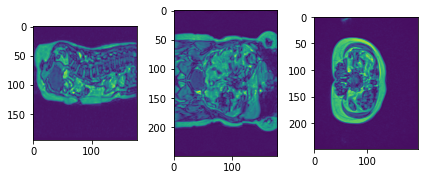

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


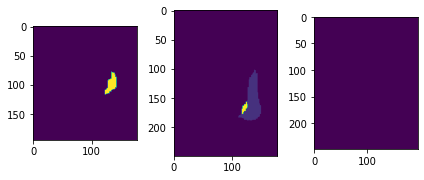

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
3387088_20201_2_0
['datasets/lablmaps/UKB/3387088_20201_2_0/3387088_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-15.nrrd_Kidney (left).nrrd', 'datasets/lablmaps/UKB/3387088_20201_2_0/3387088_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-15.nrrd_Kidney (right).nrrd', 'datasets/lablmaps/UKB/3387088_20201_2_0/3387088_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-15.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/UKB/3387088_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4.nii', 'datasets/lablmaps/UKB/3387088_20201_2_0/3387088_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-15.nrrd_Spleen.nrrd', 'datasets/lablmaps/UKB/3387088_20201_2_0/3387088_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-15.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/UKB/3387088_20201_2_0/3387088_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-15.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/3387088_20201_2_0/3387088_Dixon_BH_17s_opp

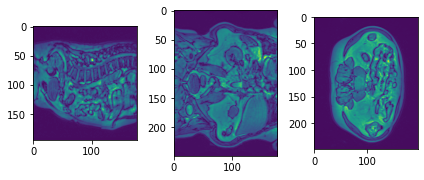

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


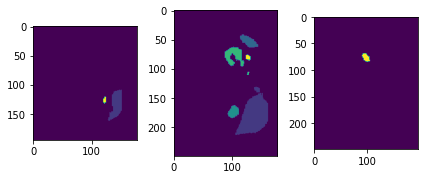

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1942395_20201_2_0
['datasets/lablmaps/UKB/1942395_20201_2_0/1942395_opp_Dixon_BH_17sa___ Spleen.nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_opp__Dixon_BH_17sa_ Liver.nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_Dixon_BH_17s_opp_Dixon_BH_17sa-3.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Kidney (left).nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_Dixon_BH_17s_opp_Dixon_BH_17sa-3.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_Dixon_BH_17s_opp_Dixon_BH_17sa-3.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/1942395_20201_2_0/1942395_Dixon_BH_17s_W_Dixon_BH_17sa.nii_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1942

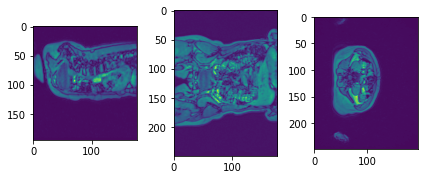

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


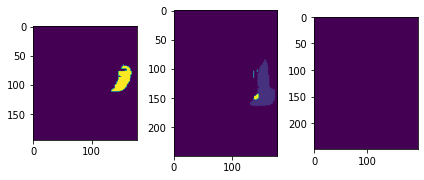

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1019631_20201_2_0
['datasets/lablmaps/UKB/1019631_20201_2_0/1019631_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/1019631_20201_2_0/1019631_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Adrenal Gland(left).nrrd', 'datasets/lablmaps/UKB/1019631_20201_2_0/1019631_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/1019631_20201_2_0/1019631_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Adrenal Gland(right).nrrd', 'datasets/lablmaps/UKB/1019631_20201_2_0/1019631_Dixon_BH_17s_opp_Dixon_BH_17s.nii_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1019631_20201_2_0/1019631_Dixon_BH_17s_opp_Dixon_BH_17s.nii_Kidney (right).nrrd', 'datasets/lablmaps/UKB/1019631_20201_2_0/1019631_opp_17s_spleen.nrrd', 'datasets/lablmaps/UKB/1019631_20201_2_0/1019631_Dixon_BH_17s_opp_Dixon_BH_17s.nii_Kidney (left).nrrd', 'datasets/lablmaps/UKB/1019631_20201_2_0/

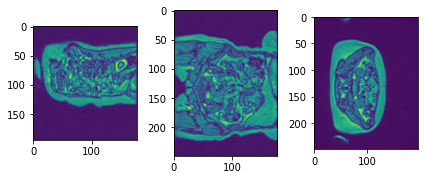

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


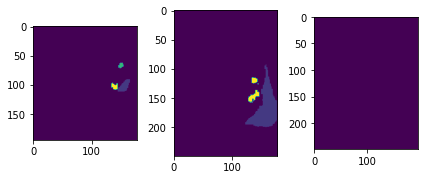

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
5764643_20201_2_0
['datasets/lablmaps/UKB/5764643_20201_2_0/5764643_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(right).nrrd', 'datasets/lablmaps/UKB/5764643_20201_2_0/5764643_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Gallbladder.nrrd', 'datasets/lablmaps/UKB/5764643_20201_2_0/5764643_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/5764643_20201_2_0/5764643_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/5764643_20201_2_0/5764643_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/5764643_20201_2_0/5764643_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(left).nrrd', 'datasets/lablmaps/UKB/5764643_20201_2_0/5764643_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(224, 174, 81)
After 3d co

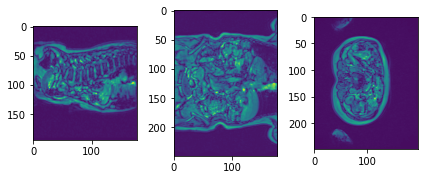

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


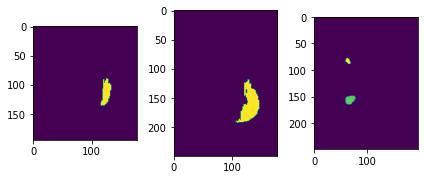

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1013250_20201_2_0
['datasets/lablmaps/UKB/1013250_20201_2_0/1013250_opp_17s_Spleen.nrrd', 'datasets/lablmaps/UKB/1013250_20201_2_0/1013250_Dixon_BH_17s_opp_Dixon_BH_17s.nii_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1013250_20201_2_0/1013250_20201_2_0_dixonn_BH_17s_opp_Liver-2-2.nrrd', 'datasets/lablmaps/UKB/1013250_20201_2_0/1013250_Dixon_BH_17s_in_Dixon_BH_17_comb_01_Adrenal gland (left).nrrd', 'datasets/lablmaps/UKB/1013250_20201_2_0/1013250_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/1013250_20201_2_0/1013250_Dixon_BH_17s_opp_Dixon_BH_17_comb_01.nii_Kidney (left)-2.nrrd', 'datasets/lablmaps/UKB/1013250_20201_2_0/1013250_Dixon_BH_17s_in_Dixon_BH_17_comb_01_Adrenal gland (right).nrrd', 'datasets/lablmaps/UKB/1013250_20201_2_0/1013250_Dixon_BH_17s_opp_Dixon_BH_17_comb_01.nii_Kidney (right)-2.nrrd', 'datasets/lablmaps/UKB/1

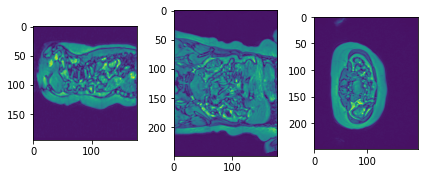

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


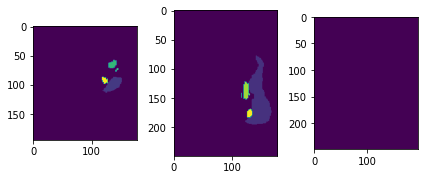

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1584559_20201_2_0
['datasets/lablmaps/UKB/1584559_20201_2_0/1584559_Dixon_BH_17s_opp_Dixon_BH_17s-2.nrrd_Adremal gland (right)nrrd (1).nrrd', 'datasets/lablmaps/UKB/1584559_20201_2_0/1584559_Dixon_BH_17s_in_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/1584559_20201_2_0/1584559_Dixon_BH_17s_opp_Dixon_BH_17s-2.nrrd_Adrenal gland(left) (1).nrrd', 'datasets/lablmaps/UKB/1584559_20201_2_0/1584559_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Kidney(left).nrrd', 'datasets/lablmaps/UKB/1584559_20201_2_0/1584559_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1584559_20201_2_0/1584559_20201_opp_Dixon_BH_17s_Spleen.nrrd', 'datasets/lablmaps/UKB/1584559_20201_2_0/1584559_Dixon_BH_17s_opp_Dixon_BH_17s-2.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/1584559_20201_2_0/Dixon_BH_17s_opp_Dixon_BH_17_comb_01.nii.gz']
Reading Files..

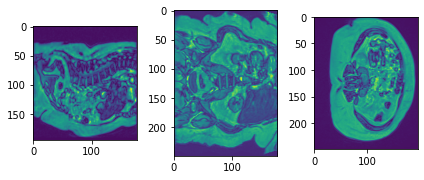

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


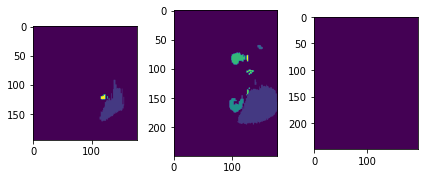

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1013391_20201_2_0
['datasets/lablmaps/UKB/1013391_20201_2_0/1013391_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Kidney (left).nrrd', 'datasets/lablmaps/UKB/1013391_20201_2_0/1013391_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Spleen.nrrd', 'datasets/lablmaps/UKB/1013391_20201_2_0/1013391_Dixon_BH_17sa_opp_Dixon_BH_17sa.nrrd_Adrenal Gland(left).nrrd', 'datasets/lablmaps/UKB/1013391_20201_2_0/1013391_Dixon_BH_17s_opp_Dixon_BH_17sa.nii_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1013391_20201_2_0/1013391_opp_17sa_liver-2.nrrd', 'datasets/lablmaps/UKB/1013391_20201_2_0/1013391_Dixon_BH_17sa_opp_Dixon_BH_17sa.nrrd_Adrenal Gland(right).nrrd', 'datasets/lablmaps/UKB/1013391_20201_2_0/1013391_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Kidney (right).nrrd', 'datasets/lablmaps/UKB/1013391_20201_2_0/1013391_Dixon_BH_17s_opp_Dixon_BH_17sa-2.nrrd_Pancreas.nrrd', 'datasets/lablmaps

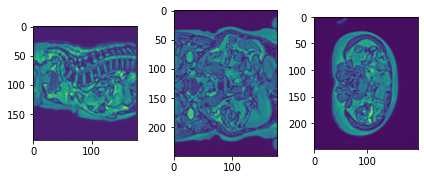

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


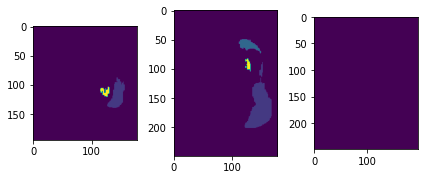

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1108214_20201_2_0
['datasets/lablmaps/UKB/1108214_20201_2_0/1108214_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-19_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/1108214_20201_2_0/1108214_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-19_Kidney (left).nrrd', 'datasets/lablmaps/UKB/1108214_20201_2_0/1108214_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-19_Spleen.nrrd', 'datasets/lablmaps/UKB/1108214_20201_2_0/1108214_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-19_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/1108214_20201_2_0/1108214_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-19_Kidney (right).nrrd', 'datasets/lablmaps/UKB/1108214_20201_2_0/1108214_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-19_Pancreas.nrrd', 'datasets/lablmaps/UKB/1108214_20201_2_0/1108214_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-19_Liver.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(224, 

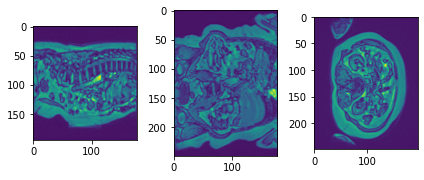

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


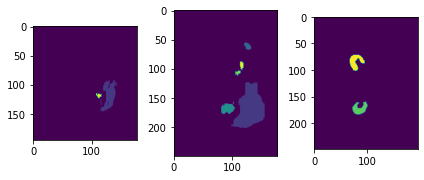

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
5397022_20201_2_0
['datasets/lablmaps/UKB/5397022_20201_2_0/5397022_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney (right).nrrd', 'datasets/lablmaps/UKB/5397022_20201_2_0/5397022_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Pancreas.nrrd', 'datasets/lablmaps/UKB/5397022_20201_2_0/5397022_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney (left).nrrd', 'datasets/lablmaps/UKB/5397022_20201_2_0/5397022_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Gallbladder.nrrd', 'datasets/lablmaps/UKB/5397022_20201_2_0/5397022_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/5397022_20201_2_0/5397022_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd', 'datasets/lablmaps/UKB/5397022_20201_2_0/5397022_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland (right).nrrd', 'datasets/lablmaps/UKB/5397022_20201_2_0/5397022_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland (left).nr

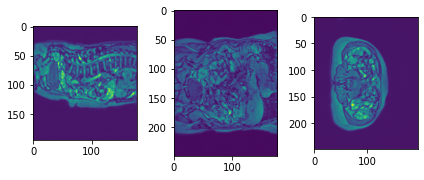

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


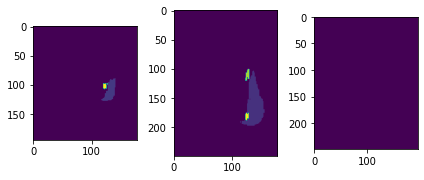

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
5934622_20201_2_0
['datasets/lablmaps/UKB/5934622_20201_2_0/5934622_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Pancreas.nrrd', 'datasets/lablmaps/UKB/5934622_20201_2_0/5934622_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd', 'datasets/lablmaps/UKB/5934622_20201_2_0/5934622_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(left).nrrd', 'datasets/lablmaps/UKB/5934622_20201_2_0/5934622_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(right).nrrd', 'datasets/lablmaps/UKB/5934622_20201_2_0/5934622_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Gallbladder.nrrd', 'datasets/lablmaps/UKB/5934622_20201_2_0/5934622_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland (right).nrrd', 'datasets/lablmaps/UKB/5934622_20201_2_0/5934622_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/5934622_20201_2_0/5934622_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland (left).nrrd

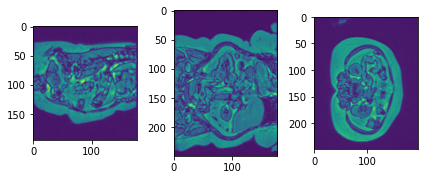

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


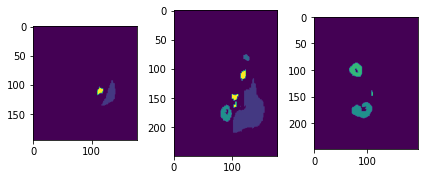

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
4154467_20201_2_0
['datasets/lablmaps/UKB/4154467_20201_2_0/4154467_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/4154467_20201_2_0/4154467_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney (left).nrrd', 'datasets/lablmaps/UKB/4154467_20201_2_0/4154467_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/4154467_20201_2_0/4154467_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd', 'datasets/lablmaps/UKB/4154467_20201_2_0/4154467_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney (right).nrrd', 'datasets/lablmaps/UKB/4154467_20201_2_0/4154467_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/4154467_20201_2_0/4154467_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Gallbladder.nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(224, 174, 81)
After 3d 

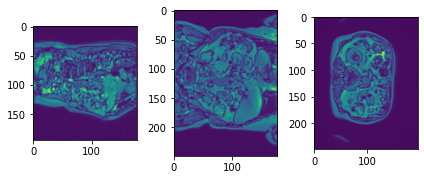

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


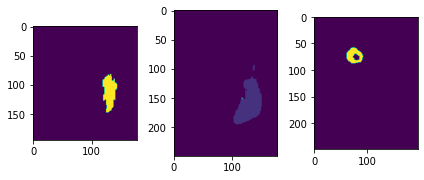

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1026125_20201_2_0
['datasets/lablmaps/UKB/1026125_20201_2_0/1026125_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-20_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/1026125_20201_2_0/1026125_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-20_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/1026125_20201_2_0/1026125_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-20_Kidney(left).nrrd', 'datasets/lablmaps/UKB/1026125_20201_2_0/1026125_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-20_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1026125_20201_2_0/1026125_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-20_Liver.nrrd', 'datasets/lablmaps/UKB/1026125_20201_2_0/1026125_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-20_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1026125_20201_2_0/1026125_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-20_Spleen.nrrd', 'datasets/lablmaps/UKB/1026125_20201_2_0/1026125_Dixon_BH_17s_opp_Dixon_BH_17_co

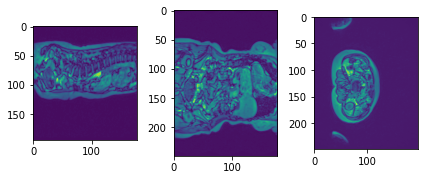

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


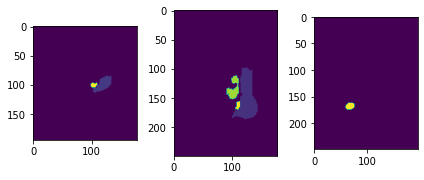

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1005379_20201_2_0
['datasets/lablmaps/UKB/1005379_20201_2_0/1005379_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Adrenal Gland(left).nrrd', 'datasets/lablmaps/UKB/1005379_20201_2_0/1005379_opp_17s_liver.nrrd', 'datasets/lablmaps/UKB/1005379_20201_2_0/1005379_opp_17s_spleen.nrrd', 'datasets/lablmaps/UKB/1005379_20201_2_0/1005379_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Adrenal Gland(right).nrrd', 'datasets/lablmaps/UKB/1005379_20201_2_0/ 1005379_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1005379_20201_2_0/1005379_Dixon_BH_17s_opp_Dixon_BH_17s-5.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/1005379_20201_2_0/1005379_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Kidney(left).nrrd', 'datasets/lablmaps/UKB/1005379_20201_2_0/1005379_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1005379_20201_2_0/Dixon_BH_17s_

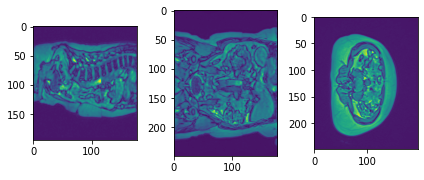

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


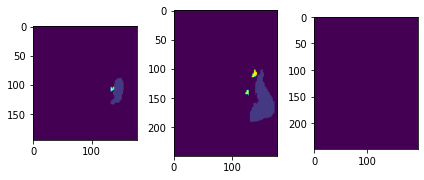

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
5371767_20201_2_0
['datasets/lablmaps/UKB/5371767_20201_2_0/5371767_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Pancreas.nrrd', 'datasets/lablmaps/UKB/5371767_20201_2_0/5371767_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/5371767_20201_2_0/5371767_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(left).nrrd', 'datasets/lablmaps/UKB/5371767_20201_2_0/5371767_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/5371767_20201_2_0/5371767_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Gallbladder.nrrd', 'datasets/lablmaps/UKB/5371767_20201_2_0/5371767_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/5371767_20201_2_0/5371767_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd', 'datasets/lablmaps/UKB/5371767_20201_2_0/5371767_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(right).nrrd']

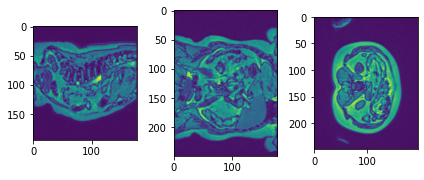

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


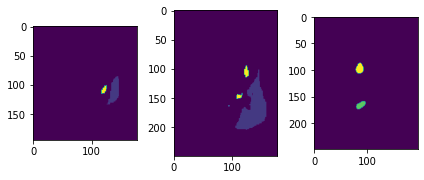

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
4627690_20201_2_0
['datasets/lablmaps/UKB/4627690_20201_2_0/4627690_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/4627690_20201_2_0/4627690_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/4627690_20201_2_0/4627690_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Pancreas.nrrd', 'datasets/lablmaps/UKB/4627690_20201_2_0/4627690_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney (right).nrrd', 'datasets/lablmaps/UKB/4627690_20201_2_0/4627690_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/4627690_20201_2_0/4627690_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd', 'datasets/lablmaps/UKB/4627690_20201_2_0/4627690_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney (left).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(224, 174, 81)
After 3d con

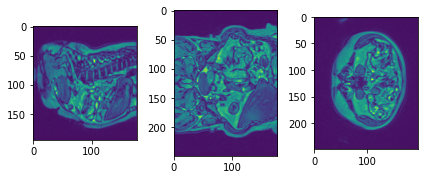

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


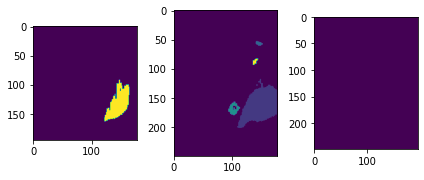

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1883132_20201_2_0
['datasets/lablmaps/UKB/1883132_20201_2_0/1883132_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/UKB/1883132_20201_2_0/1883132_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_subcutan fat.nrrd', 'datasets/lablmaps/UKB/1883132_20201_2_0/1883132_Dixon_BH_17s_opp_Dixon_BH_17s_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1883132_20201_2_0/1883132_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/1883132_20201_2_0/1883132_Dixon_BH_17s_opp_Dixon_BH_17s.nrrd_Gallblader.nrrd', 'datasets/lablmaps/UKB/1883132_20201_2_0/1883132_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Adrenal gland (left).nrrd', 'datasets/lablmaps/UKB/1883132_20201_2_0/1883132_20201_2_0_opp_17s_Spleen.nrrd', 'datasets/lablmaps/UKB/1883132_20201_2_0/1883132_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4Liver.nrrd', 'datasets/lablmaps/UKB/188313

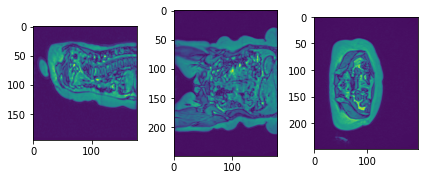

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


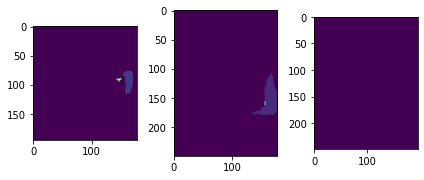

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1004985_20201_2_0
['datasets/lablmaps/UKB/1004985_20201_2_0/1004985_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Pancreas.nrrd', 'datasets/lablmaps/UKB/1004985_20201_2_0/1004985_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1004985_20201_2_0/ 1004985_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/1004985_20201_2_0/1004985_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Spleen.nrrd', 'datasets/lablmaps/UKB/1004985_20201_2_0/1004985_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Liver.nrrd', 'datasets/lablmaps/UKB/1004985_20201_2_0/1004985_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Adrenal gland (right).nrrd', 'datasets/lablmaps/UKB/1004985_20201_2_0/1004985_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1004985_20201_2_0/1004985_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_K

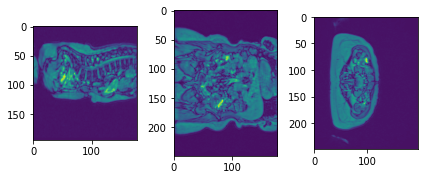

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


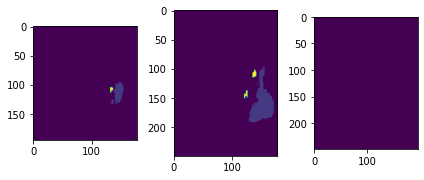

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1036900_20201_2_0
['datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Pancreas.nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Spleen.nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Kidney(left).nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Liver.nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1036900_20201_2_0/1036900_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-21_Adr

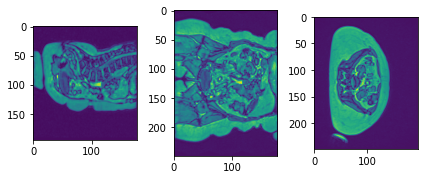

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


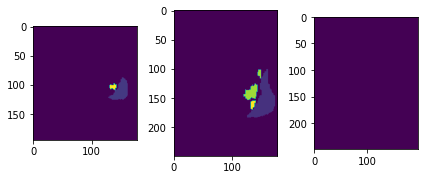

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
5833278_20201_2_0
['datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(left).nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Gallbladder.nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Pancreas.nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(right).nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/5833278_20201_2_0/5833278_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd']

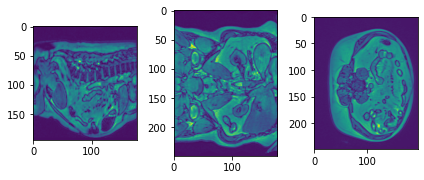

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


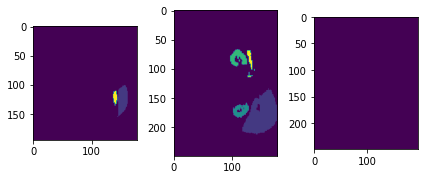

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1003082_20201_2_0
['datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_Liver.nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_opp_Dixon_BH_17sa-3_Kidney (left)-3.nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_W_Dixon_BH_17sa.nii_Gallbladder.nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_F_Dixon_BH_17sa.nrrd_Adrenal gland (left).nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_F_Dixon_BH_17sa.nrrd_Adrenal gland (right).nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_opp_17sa_spleen.nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_opp_Dixon_BH_17sa-3_Kidney(right).nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_0/1003082_Dixon_BH_17s_opp_Dixon_BH_17sa.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/1003082_20201_2_

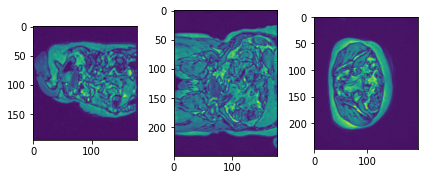

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


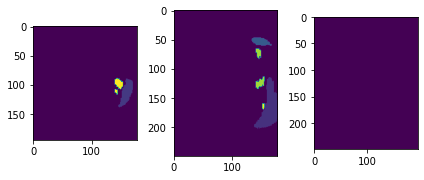

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
6025746_20201_2_0
['datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(right).nrrd', 'datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Pancreas.nrrd', 'datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd', 'datasets/lablmaps/UKB/6025746_20201_2_0/6025746_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(left).nrrd']
Reading Files.....
Reading NRRD Files.....
Transforming Images to RAS.....
(224, 174, 81)
After 3d confi

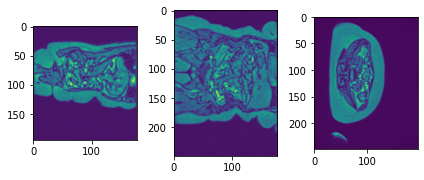

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


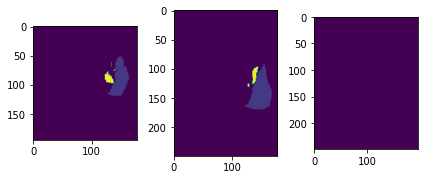

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
5331775_20201_2_0
['datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Liver.nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(right).nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Pancreas.nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(left).nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Kidney(left).nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Gallbladder.nrrd', 'datasets/lablmaps/UKB/5331775_20201_2_0/5331775_Dixon_BH_17s_opp_Dixon_BH_17_comb_01_Spleen.nrrd']

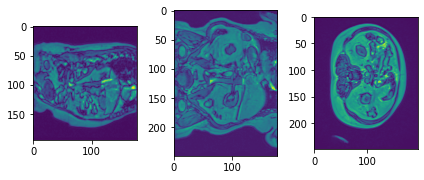

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


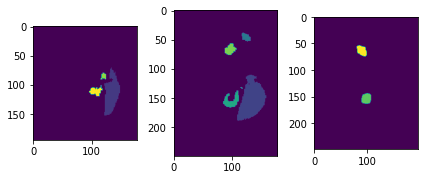

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.
1004466_20201_2_0
[]
#################### ALERT:: NO LABELPATHS IN THE DICTIONARY FOR 1004466_20201_2_0 #########################
1002359_20201_2_0
['datasets/lablmaps/UKB/1002359_20201_2_0/1002359_opp_17sb_Spleen.nii_.nrrd', 'datasets/lablmaps/UKB/1002359_20201_2_0/1002359_Dixon_BH_17s_opp_Dixon_BH_17sb.nrrd_Adrenal gland(right).nrrd', 'datasets/lablmaps/UKB/1002359_20201_2_0/1002359_Dixon_opp_BH_17sb_combi_Kidney (right).nrrd', 'datasets/lablmaps/UKB/1002359_20201_2_0/1002359_Dixon_BH_17s_opp_Dixon_BH_17_comb_01-4_KIdney(left).nrrd', 'datasets/lablmaps/UKB/1002359_20201_2_0/1002359Dixon_opp_BH_17sb.niiLiver (2)-2.nrrd', 'datasets/lablmaps/UKB/1002359_20201_2_0/1002359_Dixon_BH_17s_opp_Dixon_BH_17sb.nrrd_Pancreas.nrrd', 'datasets/lablmaps/UKB/1002359_20201_2_0/1002359_Dixon_BH_17s_opp_Dixon_BH_17sb.nrrd_Adrenal gland(left).nrrd', 'datasets/lablmaps/UK

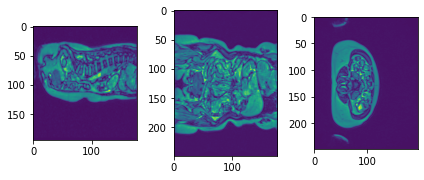

Affine:[[   2.            0.            0.         -247.7678833 ]
 [   0.            2.            0.         -191.96429443]
 [   0.            0.            3.         -630.75      ]
 [   0.            0.            0.            1.        ]], Image Shape: (250, 195, 178)


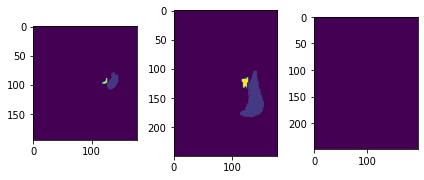

Saving Processed & Stitched Image.....
saving directory: temp/UKB/processed/volume
saving directory: temp/UKB/processed/label
FINISHED.


In [18]:
print("STARTING NAKO LABEL-MAPS.")
print('Reading Label Maps.....')
for vol in file_paths.keys():
    print(vol)
    if vol_to_check_list is not None and vol not in vol_to_check_list:
        continue
    later = None
    print(file_paths[vol]['LABEL_PATHS'])
    if len(file_paths[vol]['LABEL_PATHS']) == 0:
        print(f"#################### ALERT:: NO LABELPATHS IN THE DICTIONARY FOR {vol} #########################")
        continue
        
    volume = nb.load(file_paths[vol]['N4_2']['OPP_CORRECTED'])
#     volume = nb.load(file_paths[vol]['ONE']['OPP'])
    img_ras_list = []
    for label_file_to_read in file_paths[vol]['LABEL_PATHS']:
        img_ras, lidx, labelname = read_ras(label_file_to_read, is_label=True)
        if labelname is None or img_ras is None:
            continue
        print(img_ras.shape)
        img_ras = makeit_3d(img_ras)
        print('After 3d confirmed:', img_ras.shape)
        mode='constant'
        img_ras = resample_to_output(img_ras, TARGET_RESOLUTION, order=0, mode=mode, cval=0.0)
#         img_ras = labels_integerify(img_ras)
    #     img_ras = resample_from_to(img_ras, [volume.shape, img_ras.affine])
        if labelname == 'SPLEEN':
            later = [img_ras, lidx, labelname]
        else:
            img_ras_list.append([img_ras, lidx, labelname])
    if later is not None:
        img_ras_list.append(later)
        
    s_label = label_parts(img_ras_list)
    volume, s_label = ukb_vol_label_fix(volume, s_label)
    #     volume, stitched_label = combine_nako_seg(file_paths[vol]['LABEL_PATHS'],'' ,file_paths[vol]['N4_2']['OPP_CORRECTED'])

    print('Viewing Stitched Images.....')
    volume_3_view_viewer(get_volume_data(volume))

    volume_3_view_viewer(get_volume_data(s_label))

    print('Saving Processed & Stitched Image.....')
    save_volume(volume, f'{processed_dir}/volume/{vol}')
    save_volume(s_label, f'{processed_dir}/label/{vol}')
    print('FINISHED.')
    
    


In [ ]:
visualize_overlay(file_paths)

In [ ]:
print(json.dumps(file_paths, indent=4))

In [ ]:
# file_dict= 
# {
#     VOL_ID: {
#         VOLUME_PATHS: {
#             OPP: [],
#             IN: [],
#             F: [],
#             W: []
#         },
#         LABEL_PATHS: [],
#         N4_1: [
#             {
#                 SCALED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled.nii.gz',
#                 IN_BIAS: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_bias_field.nii.gz',
#                 IN_CORRECTED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_corrected.nii.gz',
#                 OPP_CORRECTED: '',
#                 MIN: u_min,
#                 MAX: u_max
#             },
#             {},
#             {}
#         ],
#         ONE: {
#             OPP: '',
#             IN: '',
#             F: '',
#             W: '',
#         },
#         N4_2: {
#             SCALED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled.nii.gz',
#             IN_BIAS: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_bias_field.nii.gz',
#             IN_CORRECTED: f'{n4_corrected_data_dir}/vol/{vol_id}/{new_filename}_n4_scaled_corrected.nii.gz',
#             OPP_CORRECTED: '',
#             MIN: u_min,
#             MAX: u_max
#         },
        
#     }
# }